In [24]:
import heapq
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import metrics

# Load the data

In [25]:
source_corpus = []
source_labels = []
files = [
    'kamerstukken_topics-multi_20120101_20120630.json',
    'kamerstukken_topics-multi_20130101_20130630.json',
    'kamerstukken_topics-multi_20140101_20141231.json',
    'kamerstukken_topics-multi_20160602_20161201.json',
    'kamerstukken_topics-multi_20160101_20160601.json',
    'kamerstukken_topics-multi_20170101_20170301.json',
    'kamerstukken_topics-multi_20170302_20170601.json',
    'kamerstukken_topics-multi_20170602_20180101.json',
    'kamerstukken_topics-multi_20180101_20180401.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
        if len(obj['categories']) > 0 and 'Antwoord' not in obj['content']:
            source_corpus.append(obj['content'])
            source_labels.append(obj['categories'])


print(len(source_corpus))
print(len(source_labels))

13948
13948


In [26]:
unlabeled_corpus = []
files = [
    'poliflw_target_unlabeled.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
        unlabeled_corpus.append(obj['content'])

print(len(unlabeled_corpus))

40000


In [27]:
target_corpus = []
target_labels = []
files = [
    'poliflw_target_labeled_data_checked.json'
]

for file in files:
    data = json.load(open('../../data_resources/topics/kamerstukken/{}'.format(file)))
    for obj in data:
#         source_corpus.append(obj['content'])
#         source_labels.append(obj['categories'])
        
        target_corpus.append(obj['content'])
        target_labels.append(obj['categories'])


print(len(target_corpus))
print(len(target_labels))

164
164


# Define helper functions and constants

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=2, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    
    
    
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scorer)
    

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    print(train_scores)
    print(np.shape(train_scores_mean))

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [118]:
def pre_process(s):
    result = ''.join([i for i in s if not i.isdigit()])
    return result.upper()

def predict_multi_always(clf, x):
    y_pred = clf.predict(x)
    y_prob = clf.predict_proba(x)
    
    for sample_index in range(0,len(y_pred)):
        most_probable_label = np.where(y_prob[sample_index] == max(y_prob[sample_index]))[0][0]
        y_pred[sample_index][most_probable_label] = 1
        
    return y_pred

def train_clf(corpus, labels):
    transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
    mlb = MultiLabelBinarizer()
    
    X = transformer.fit_transform(corpus)
    y = mlb.fit_transform(labels)
    
    clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
    clf = OneVsRestClassifier(clf).fit(X, y)
    
    return transformer, mlb, clf

def merge_training_data(original_corpus, unlabeled_corpus, original_labels, unlabeled_predictions):
    new_corpus = []
    new_labels = []
    
    for i in range(0,len(original_corpus)):
        new_corpus.append(original_corpus[i])
        new_labels.append(original_labels[i])
        
    for i in range(0,len(unlabeled_predictions)):
        new_corpus.append(unlabeled_corpus[i])
        
        labels = []
        for pred in unlabeled_predictions[i]:
            labels.append(pred)
        new_labels.append(labels)
    
    return new_corpus, new_labels

def evaluate_target_domain(transformer, mlb, clf, corpus, labels):
    X = transformer.transform(corpus)
    y = mlb.transform(labels)
    
    y_pred = clf.predict(X)
    
    p = precision_score(y, y_pred, average='micro')
    r = recall_score(y, y_pred, average='micro')
    f1 = f1_score(y, y_pred, average='micro')
    
    print('P,R,F1')
    print(p)
    print(r)
    print(f1)
    
    return [p, r, f1]

# Evaluate initial classifier

In [123]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
mlb = MultiLabelBinarizer()
    
X = transformer.fit_transform(source_corpus)
y = mlb.fit_transform(source_labels)
clf = OneVsRestClassifier(clf).fit(X,y)

In [124]:
evaluate_target_domain(transformer, mlb, clf, target_corpus, target_labels)

P,R,F1
0.5092592592592593
0.2511415525114155
0.3363914373088685


[0.5092592592592593, 0.2511415525114155, 0.3363914373088685]

# Train the classifier
1. Train a classifier on source corpus
2. Classify unlabeled data
3. Add uonlabeled corpus + predictions to labeled data
4. Retrain classifier

In [6]:
t, m, c = train_clf(source_corpus, source_labels)

In [ ]:
y_pred = c.predict(t.transform(unlabeled_corpus))

print(y_pred[0])

In [ ]:
evaluate_target_domain(t, m, c, target_corpus, target_labels)

In [ ]:
t, m, c = train_clf(source_corpus, source_labels)
evaluate_target_domain(t, m, c, source_corpus, source_labels)
evaluate_target_domain(t, m, c, target_corpus, target_labels)

In [70]:
min(100,2)

2

# Soft self-labeling - does not work
Eigenlijk om dit echt om deze manier te testen (met plots) moeten we een soort van crossvalidation doen waarbij we slechts 80% van de data gebruiken. Anders kunnen we lucky zijn.

P,R,F1
0.5045871559633027
0.24444444444444444
0.32934131736526945
#labeled: 13948. #unlabeled: 40000, TOP_N: 500
39789
P,R,F1
0.6666666666666666
0.14222222222222222
0.23443223443223443


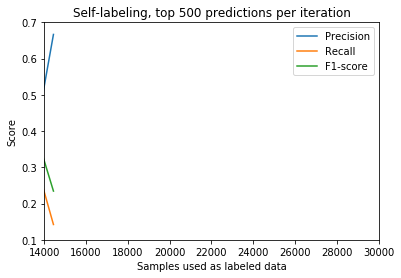

#labeled: 14448. #unlabeled: 39500, TOP_N: 500
39291
P,R,F1
0.546875
0.15555555555555556
0.24221453287197234


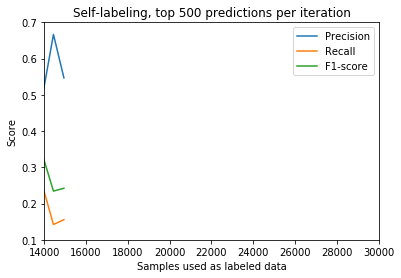

#labeled: 14948. #unlabeled: 39000, TOP_N: 500
38902
P,R,F1
0.5238095238095238
0.14666666666666667
0.22916666666666669


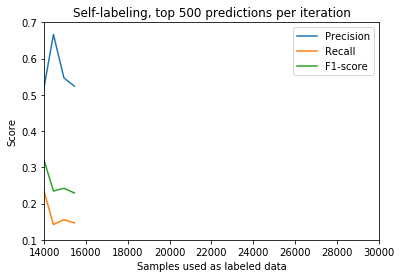

#labeled: 15448. #unlabeled: 38500, TOP_N: 500
38336
P,R,F1
0.5142857142857142
0.16
0.24406779661016947


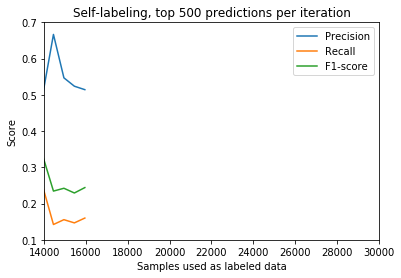

#labeled: 15948. #unlabeled: 38000, TOP_N: 500
37992
P,R,F1
0.4852941176470588
0.14666666666666667
0.22525597269624575


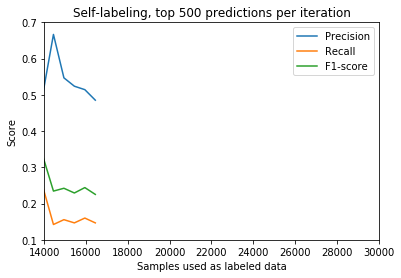

#labeled: 16448. #unlabeled: 37500, TOP_N: 500
37467
P,R,F1
0.5409836065573771
0.14666666666666667
0.23076923076923078


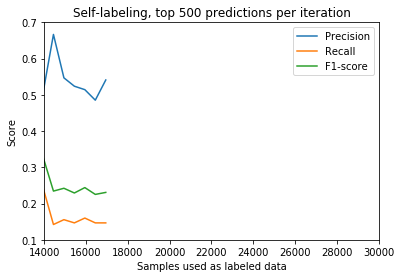

#labeled: 16948. #unlabeled: 37000, TOP_N: 500
36942
P,R,F1
0.5245901639344263
0.14222222222222222
0.22377622377622375


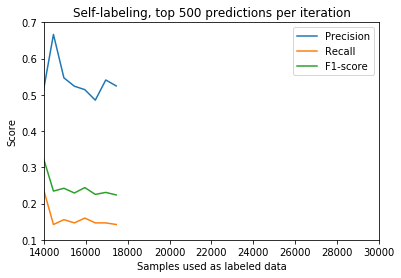

#labeled: 17448. #unlabeled: 36500, TOP_N: 500
36495
P,R,F1
0.375
0.16
0.22429906542056072


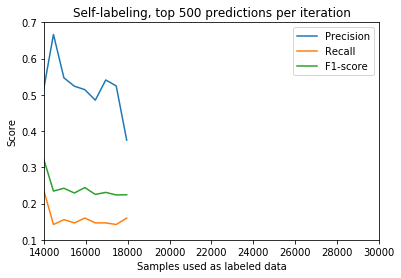

#labeled: 17948. #unlabeled: 36000, TOP_N: 500


KeyboardInterrupt: 

In [15]:
def adapt_domain(step, transformer, mlb, clf, c_labeled_param, l_labeled_param, c_target_param, l_target_param, c_unlabeled_param):
    c_labeled = []
    l_labeled = []
    c_unlabeled = []
    
    for obj in c_labeled_param:
        c_labeled.append(obj)
        
    for obj in l_labeled_param:
        l_labeled.append(obj)
        
    for obj in c_unlabeled_param:
        c_unlabeled.append(obj)
        
    x = []
    py = []
    ry = []
    f1y = []
    
    [p, r, f1] = evaluate_target_domain(transformer, mlb, clf, c_target_param, l_target_param)
        
    x.append(len(c_labeled))
    py.append(p)
    ry.append(r)
    f1y.append(f1)
        
    while len(c_unlabeled) > 0:
    
        TOP_N = min(step, len(c_unlabeled))
    
        print('#labeled: {}. #unlabeled: {}, TOP_N: {}'.format(len(c_labeled), len(c_unlabeled), TOP_N))

        # Get the most certain probability scores on labels.
        y_pred = clf.predict(transformer.transform(c_unlabeled))
        y_probas = clf.predict_proba(transformer.transform(c_unlabeled))
        y_max_probas = []

        for y in y_probas:
            y_max_probas.append(np.max(y))

        y_max_probas = np.array(y_max_probas)
        top_prob_indices = np.array(heapq.nlargest(TOP_N, range(len(y_max_probas)), y_max_probas.take))

        # Add these labels to labeled data (corpus and labels) and remove them from the unlabeled corpus.
        print(max(top_prob_indices))
        for i in top_prob_indices:
            c_labeled.append(c_unlabeled[i])

        for labels in mlb.inverse_transform(y_pred[top_prob_indices]):
            l_labeled.append(labels)

        new_unlabeled = []    
        for i in range(0,len(c_unlabeled)):
            if i not in top_prob_indices:
                new_unlabeled.append(c_unlabeled[i])
        c_unlabeled = new_unlabeled

        # Retrain classifier
    #     print('Retrain classifier')
        t1, m1, c1 = train_clf(c_labeled, l_labeled)

        # Evaluate target domain.
    #     print('Evaluating Target Domain')
        [p, r, f1] = evaluate_target_domain(t1, m1, c1, c_target_param, l_target_param)
        
        x.append(len(c_labeled))
        py.append(p)
        ry.append(r)
        f1y.append(f1)
    
        plt.plot(x, py, label='Precision')
        plt.plot(x, ry, label='Recall')
        plt.plot(x, f1y, label='F1-score')
        plt.xlabel('Samples used as labeled data')
        plt.ylabel('Score')
        plt.xlim(xmax=30000)
        plt.xlim(xmin=14000)
        plt.ylim(ymin=0.1,ymax=0.7)
        plt.title('Self-labeling, top {} predictions per iteration'.format(step))
        plt.legend()
        plt.show()
    
    return c1


t, m, c = train_clf(source_corpus, source_labels)

clf_adapted = adapt_domain(500, t, m, c, source_corpus, source_labels, target_corpus, target_labels, unlabeled_corpus)

In [22]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
transformer = transformer.fit(unlabeled_corpus)

X = transformer.fit_transform(source_corpus)
y = mlb.fit_transform(source_labels)

clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X, y)


p, r, f1 = evaluate_target_domain(transformer, mlb, clf, source_corpus, source_labels)
print(p)
print(r)
print(f1)

KeyboardInterrupt: 

# TFIDF

In [77]:
import random

P,R,F1
0.05555555555555555
0.1963470319634703
0.0866062437059416
P,R,F1
0.032318210068365445
0.2374429223744292
0.05689277899343545
P,R,F1
0.036734693877551024
0.2465753424657534
0.06394316163410303


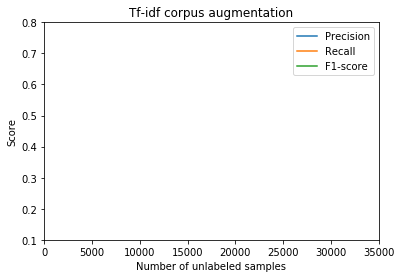

P,R,F1
0.15609756097560976
0.2922374429223744
0.20349761526232113
P,R,F1
0.15517241379310345
0.2876712328767123
0.20159999999999997
P,R,F1
0.16752577319587628
0.2968036529680365
0.21416803953871497


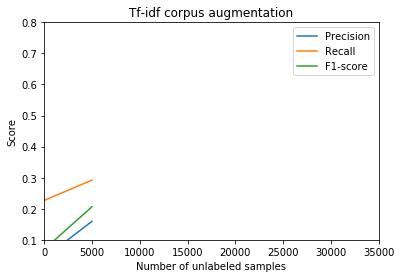

P,R,F1
0.19682539682539682
0.2831050228310502
0.23220973782771534
P,R,F1
0.24545454545454545
0.3698630136986301
0.29508196721311475
P,R,F1
0.21282798833819241
0.3333333333333333
0.2597864768683274


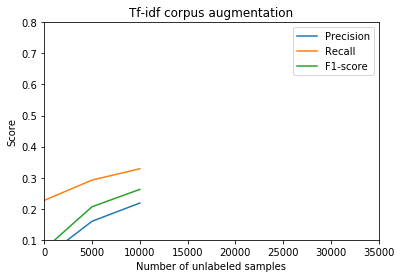

P,R,F1
0.24916943521594684
0.3424657534246575
0.28846153846153844
P,R,F1
0.19932432432432431
0.2694063926940639
0.229126213592233
P,R,F1
0.2129032258064516
0.3013698630136986
0.24952741020793948


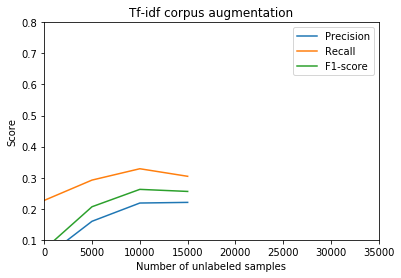

P,R,F1
0.25
0.3287671232876712
0.28402366863905326
P,R,F1
0.240625
0.3515981735159817
0.2857142857142857
P,R,F1
0.24496644295302014
0.3333333333333333
0.2823984526112186


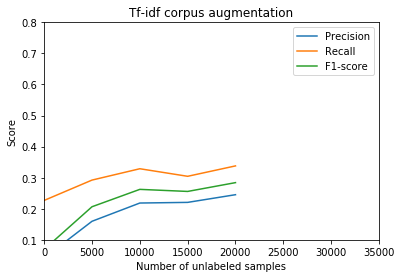

P,R,F1
0.25539568345323743
0.3242009132420091
0.2857142857142857
P,R,F1
0.23322683706070288
0.3333333333333333
0.2744360902255639
P,R,F1
0.24752475247524752
0.3424657534246575
0.28735632183908044


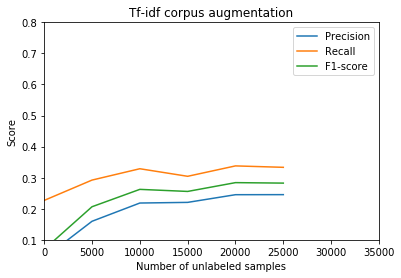

P,R,F1
0.2757352941176471
0.3424657534246575
0.3054989816700611
P,R,F1
0.2508591065292096
0.3333333333333333
0.2862745098039216
P,R,F1
0.26148409893992935
0.3378995433789954
0.2948207171314741


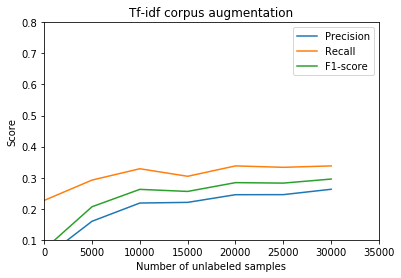

P,R,F1
0.26811594202898553
0.3378995433789954
0.29898989898989903
P,R,F1
0.27715355805243447
0.3378995433789954
0.3045267489711934
P,R,F1
0.2631578947368421
0.3424657534246575
0.2976190476190476


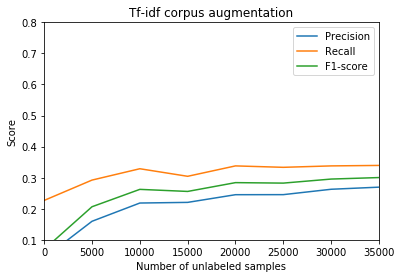

In [81]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
mlb = MultiLabelBinarizer()


x = []
py = []
ry = []
f1y = []

for i in range(0,40000,5000):
    
    pyi = []
    ryi = []
    f1yi = []
    
    for j in range(0,3):
    
        tfidf_corpus = []
        for obj in random.sample(unlabeled_corpus, i):
            tfidf_corpus.append(obj)

#         for obj in source_corpus:
#             tfidf_corpus.append(obj)

        transformer = None
        transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
        transformer = transformer.fit(tfidf_corpus)

        X = transformer.transform(source_corpus)
        y = mlb.fit_transform(source_labels)

        clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
        clf = OneVsRestClassifier(clf).fit(X, y)

    #     evaluate_target_domain(transformer, mlb, clf, source_corpus, source_labels)
        p, r, f1 = evaluate_target_domain(transformer, mlb, clf, target_corpus, target_labels)
        
        pyi.append(p)
        ryi.append(r)
        f1yi.append(f1)
    
    x.append(i)
    py.append(np.mean(pyi))
    ry.append(np.mean(ryi))
    f1y.append(np.mean(f1yi))
    
    plt.plot(x, py, label='Precision')
    plt.plot(x, ry, label='Recall')
    plt.plot(x, f1y, label='F1-score')
    plt.xlabel('Number of unlabeled samples')
    plt.ylabel('Score')
    plt.xlim(xmax=35000)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0.1,ymax=0.8)
    plt.title('Tf-idf corpus augmentation')
    plt.legend()
    plt.show()

In [119]:
tfidf_corpus = []
for obj in unlabeled_corpus:
    tfidf_corpus.append(obj)

for obj in source_corpus:
    tfidf_corpus.append(obj)
    
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
transformer = transformer.fit(tfidf_corpus)

X = transformer.transform(source_corpus)
y = mlb.fit_transform(source_labels)

clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X, y)

#     evaluate_target_domain(transformer, mlb, clf, source_corpus, source_labels)
p, r, f1 = evaluate_target_domain(transformer, mlb, clf, target_corpus, target_labels)

P,R,F1
0.44516129032258067
0.3150684931506849
0.3689839572192513


# Threshold adjustment

In [110]:
def predict_threshold(clf, x, t):
    y_pred = clf.predict(x)
    y_prob = clf.predict_proba(x)
    
    for sample_index in range(0,len(y_pred)):
        
        for label_index in range(0, len(y_prob[sample_index])):
            
            if y_prob[sample_index][label_index] > t:
                y_pred[sample_index][label_index] = 1
            else:
                y_pred[sample_index][label_index] = 0
        
    return y_pred

def train_clf(corpus, labels):
    transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
    mlb = MultiLabelBinarizer()
    
    X = transformer.fit_transform(corpus)
    y = mlb.fit_transform(labels)
    
    clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
    clf = OneVsRestClassifier(clf).fit(X, y)
    
    return transformer, mlb, clf

def evaluate_target_threshold(transformer, mlb, clf, threshold, corpus, labels):
    X = transformer.transform(corpus)
    y = mlb.transform(labels)
    
    y_pred = predict_threshold(clf, X, threshold)
    
    p = precision_score(y, y_pred, average='micro')
    r = recall_score(y, y_pred, average='micro')
    f1 = f1_score(y, y_pred, average='micro')
    
    print('P,R,F1')
    print(p)
    print(r)
    print(f1)
    
    return [p, r, f1]


0.0
-----
P,R,F1
0.012030323005932762
1.0
0.023774629539163004

0.05
-----
P,R,F1
0.09515570934256055
0.502283105022831
0.16

0.1
-----
P,R,F1
0.15615141955835962
0.4520547945205479
0.23212192262602577

0.15000000000000002
-----
P,R,F1
0.19703389830508475
0.4246575342465753
0.2691751085383502

0.2
-----
P,R,F1
0.24258760107816713
0.410958904109589
0.3050847457627119

0.25
-----
P,R,F1
0.2783171521035599
0.3926940639269406
0.3257575757575758

0.30000000000000004
-----
P,R,F1
0.2872727272727273
0.3607305936073059
0.31983805668016196

0.35000000000000003
-----
P,R,F1
0.3206751054852321
0.3470319634703196
0.3333333333333333

0.4
-----
P,R,F1
0.38144329896907214
0.3378995433789954
0.3583535108958838

0.45
-----
P,R,F1
0.4260355029585799
0.3287671232876712
0.3711340206185567

0.5
-----
P,R,F1
0.44516129032258067
0.3150684931506849
0.3689839572192513

0.55
-----
P,R,F1
0.5074626865671642
0.3105022831050228
0.3852691218130312

0.6000000000000001
-----
P,R,F1
0.5327868852459017
0.2968036529680

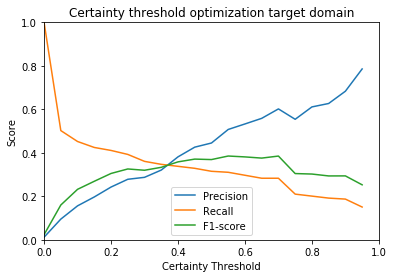

In [122]:
tfidf_corpus = []
for obj in unlabeled_corpus:
    tfidf_corpus.append(obj)

for obj in source_corpus:
    tfidf_corpus.append(obj)
    
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
transformer = transformer.fit(tfidf_corpus)

X = transformer.transform(source_corpus)
y = mlb.fit_transform(source_labels)

clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X, y)

x = []
p = []
r = []
f1 = []

for i in np.arange(0.0, 1.0, 0.05):
    print('\n{}\n-----'.format(i))
    
    pi, ri, f1i = evaluate_target_threshold(transformer, mlb, clf, i, target_corpus, target_labels)
    
    x.append(i)
    p.append(pi)
    r.append(ri)
    f1.append(f1i)

plt.plot(x, p, label='Precision')
plt.plot(x, r, label='Recall')
plt.plot(x, f1, label='F1-score')
plt.xlabel('Certainty Threshold')
plt.ylabel('Score')
plt.xlim(xmax=1.0)
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0,ymax=1.0)
plt.title('Certainty threshold optimization target domain')
plt.legend()
plt.show()

# Check errors

In [16]:
transformer = TfidfVectorizer(max_df=0.7, preprocessor=pre_process)
mlb = MultiLabelBinarizer()
transformer = transformer.fit(source_corpus)

X_train = transformer.transform(source_corpus)
y_train = mlb.fit_transform(source_labels)

clf = SGDClassifier(loss='log', penalty='none', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X_train, y_train)

X_test = transformer.transform(target_corpus)
y_test = mlb.transform(target_labels)

y_pred = clf.predict(X_test)

In [17]:
for i in range(0,len(y_pred)):
    if y_test[i].all() == y_pred[i].all():

        print(mlb.inverse_transform(y_test[[i]]))        
        print(mlb.inverse_transform(y_pred[[i]]))
        
        print(target_corpus[i][0:50])


# misclassified_objects = target_corpus[y_pred != y_test]

# for obj in misclassified_objects:
#     print(obj[0:100])

[('Bestuur | Gemeenten', 'Natuur en milieu | Organisatie en beleid')]
[()]
Zorg voor milieu en klimaat  Hoe graag zouden we n
[('Bestuur | Gemeenten',)]
[()]
Wat doet een gemeenteraadsfractie nu eigenlijk als
[('Bestuur | Gemeenten',)]
[('Bestuur | Organisatie en beleid',)]
Op 21 maart vechten we om de steun van 32.260 kies
[('Bestuur | Gemeenten',)]
[()]
KANSEN ZIEN voor Nuenen, stem juist nu op het CDA!
[('Bestuur | Gemeenten',)]
[('Financiën | Belasting',)]
Verandering begint in ’s-Hertogenbosch. Zeker als 
[('Bestuur | Gemeenten',)]
[()]
Even voorstellen: Kristel Bottinga, nummer 3 op de
[('Zorg en gezondheid | Jongeren',)]
[('Zorg en gezondheid | Jongeren',)]
De ChristenUnie en jongerenorganisatie PerspectieF
[('Bestuur | Gemeenten', 'Bestuur | Organisatie en beleid')]
[()]
Na het verkiezingsdebat van 14 maart 2018 in Place
[()]
[()]
Wat een mooie campagnedag afgelopen zaterdag! Tien
[('Openbare orde en veiligheid | Organisatie en beleid',)]
[()]
Mark RutteWe leven in een onrustig

# OLD
# -------

# Evaluate classifier on test data

In [53]:
y_source = mlb.fit_transform(source_labels)
y_target = mlb.transform(target_labels)

In [54]:

X_source = transformer.fit_transform(source_corpus)
X_target = transformer.transform(target_corpus)

print(np.shape(X_source))

(12160, 14113)


In [55]:
clf = SGDClassifier(loss='log', penalty='l1', alpha=1e-6, random_state=42, max_iter=10)
clf = OneVsRestClassifier(clf).fit(X_source, y_source)

In [56]:
X_s = transformer.transform(unlabeled_corpus[0:2])

res = clf.predict(X_s)

for obj in res:
    if 1 in obj:
        print(obj)

In [57]:
semi_corpus = source_

P score: 0.28
R score: 0.20
F1 score: 0.24
